# Classification. Linear models and KNN

In [1409]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1410]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [1411]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#==============================================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [1412]:
np.random.seed(31415)

In [1413]:
PATH = "./data/"

In [1414]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [1415]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1416]:
data.shape

(891, 11)

In [1417]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [1418]:
data['SexBin'] = data.apply(lambda row: 1 if row['Sex'] == 'male' else 0, axis=1)

# data = pd.get_dummies(data=data, columns=["Sex"], drop_first=True)
# data = pd.get_dummies(data, columns=["Embarked"],drop_first=True)
#display(data)

data.groupby('Sex').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,SexBin
Sex,,,,,,,
female,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.0
male,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,1.0


total male=577
total female=314


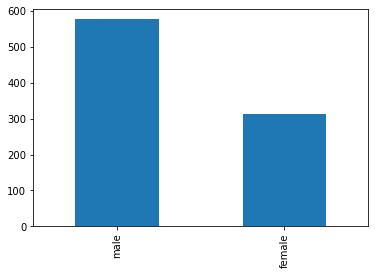

survived male=109
survived female=233


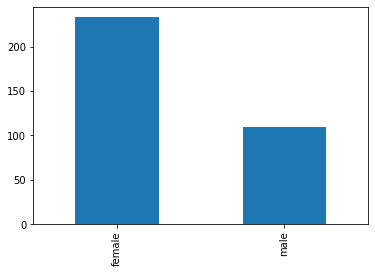

correlation Sex and Survival=0.5433513806577551
Sex       female  male
Survived              
0             81   468
1            233   109


<AxesSubplot:xlabel='Survived'>

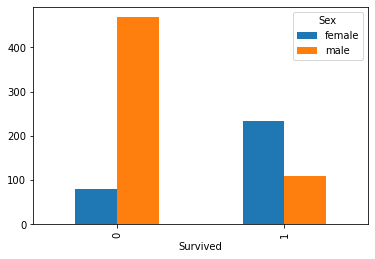

In [1419]:
print('total male={}'.format((data['Sex'] == 'male').sum()))
print('total female={}'.format((data['Sex'] == 'female').sum()))
# male = data[data['Sex'] == 'male']
# display(male)
#female = data[data['Sex'] == 'female']
# display(female)

data['Sex'].value_counts().plot(kind='bar', sort_columns=True)
plt.show()

survived = data[data['Survived'] == 1]
print('survived male={}'.format((survived['Sex'] == 'male').sum()))
print('survived female={}'.format((survived['Sex'] == 'female').sum()))
survived['Sex'].value_counts().plot(kind='bar', sort_columns=True)
plt.show()

corr_sex_surv = data['SexBin'].corr(data['Survived'])
print(f'correlation Sex and Survival={np.abs(corr_sex_surv)}')
data.drop(columns=['SexBin'], axis=1, inplace=True)


groupof = data.groupby('Survived')['Sex']
print(groupof.value_counts().unstack())
groupof.value_counts().unstack().plot(kind="bar",stacked=False)

**Вывод:** Пол влияет на вероятность быть спасенным - спасенных женщин больше чем мужчин, хотя изначально соотношение обратное. корреляция существует, хоть и не самая большая - 0.5433513806577551

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

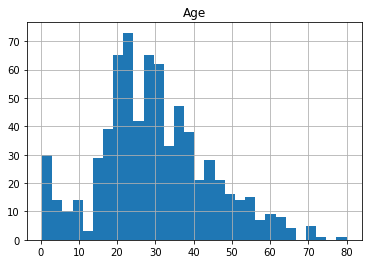

avg_age = 29.69911764705882
median_age = 28.0


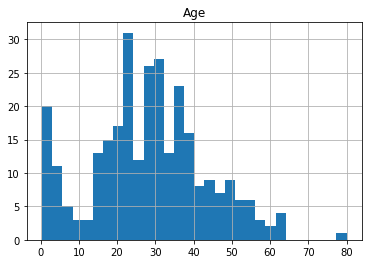

survived_avg_age = 28.343689655172415
survived_median_age = 28.0


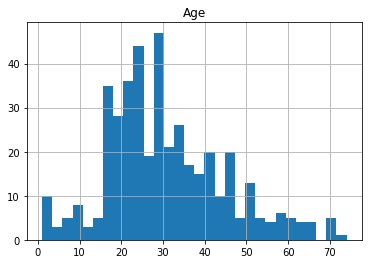

deceased_avg_age = 30.62617924528302
deceased_median_age = 28.0


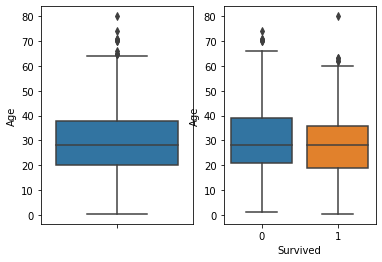

In [1420]:
data.hist(column='Age', bins=30)
plt.show()

avg_age = data['Age'].mean()
print(f'avg_age = {avg_age}')
median_age = data['Age'].median()
print(f'median_age = {median_age}')

data[data['Survived'] == 1].hist(column='Age', bins=30)
plt.show()
survived_avg_age = data[data['Survived'] == 1]['Age'].mean()
print(f'survived_avg_age = {survived_avg_age}')
survived_median_age = data[data['Survived'] == 1]['Age'].median()
print(f'survived_median_age = {survived_median_age}')

data[data['Survived'] == 0].hist(column='Age', bins=30)
plt.show()
deceased_avg_age = data[data['Survived'] == 0]['Age'].mean()
print(f'deceased_avg_age = {deceased_avg_age}')
deceased_median_age = data[data['Survived'] == 0]['Age'].median()
print(f'deceased_median_age = {deceased_median_age}')

# fig, axs = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2, 1)
sns.boxplot( y='Age', data=data);
plt.subplot(1,2, 2)
sns.boxplot(x='Survived', y='Age', data=data);
plt.show()

**Выводы:** ка видно из boxplot медианне значение возраста спасенных и погибших одинаково (28). Спаслись более молодые пассжиры: средний возраст спасенных выше среднего возраста погибших (28.34 и 30.62), из boxplot видно что при одинаковых медианах у спасенных "ящик" смеещен вниз (более молодой возраст)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

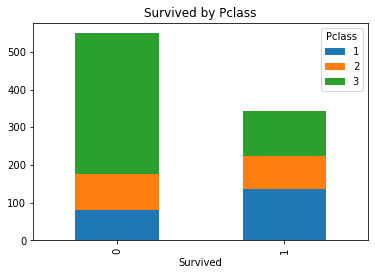

1    0.629630
2    0.472826
3    0.242363
Name: Pclass, dtype: float64

<AxesSubplot:title={'center':'Rate survived by Pclass'}>

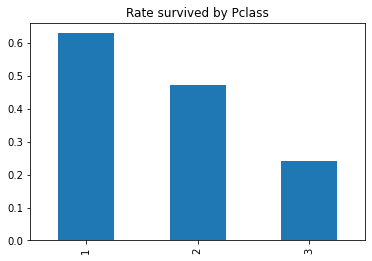

In [1421]:
groupof = data.groupby('Survived')['Pclass']
groupof.value_counts().unstack().plot(kind="bar",stacked="True", title='Survived by Pclass')
plt.show()

total_pclass = data['Pclass'].value_counts()
survived_pclass = groupof.value_counts()[1]
rate_p_s = survived_pclass / total_pclass
display(rate_p_s)

rate_p_s.plot(kind="bar",stacked="True", title='Rate survived by Pclass')

1-ый класс самый безопастный, т.к. процент выживших из 1-го класса наивысший (62.96)

Survived,0,1,t,sr
Embarked,,,,
C,75,93,168,0.553571
Q,47,30,77,0.389610
S,427,217,644,0.336957


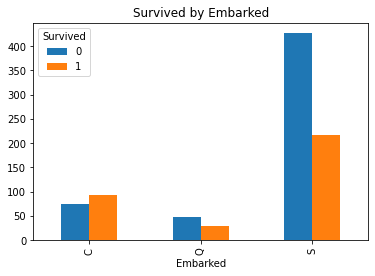

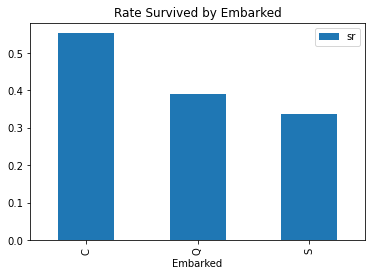

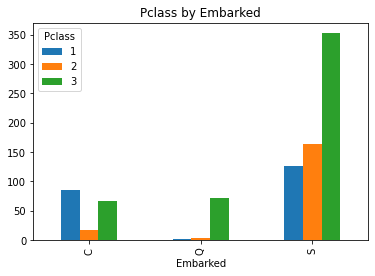

Pclass,1,2,3,t,1r,2r,3r
Embarked,,,,,,,
C,85,17,66,168,0.505952,0.101190,0.392857
Q,2,3,72,77,0.025974,0.038961,0.935065
S,127,164,353,644,0.197205,0.254658,0.548137


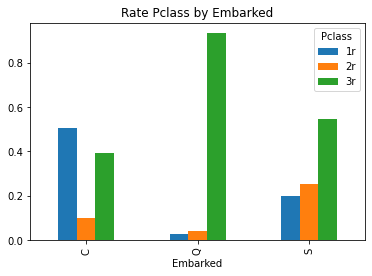

Embarked,C,Q,S
Pclass,,,
1,85,2,127
2,17,3,164
3,66,72,353


In [1422]:
groupof = data.groupby('Embarked')['Survived']
e_s = groupof.value_counts().unstack()
e_s['t'] = e_s.sum(axis=1)
e_s['sr'] = e_s[1]/e_s['t']
display(e_s)
groupof.value_counts().unstack().plot(kind="bar",stacked=False, title='Survived by Embarked')
plt.show()
e_s.plot(y='sr', kind="bar", title='Rate Survived by Embarked')
plt.show()

groupof = data.groupby('Embarked')['Pclass']
p_e = groupof.value_counts().unstack()
p_e.plot(kind="bar",stacked=False, title='Pclass by Embarked')
plt.show()
p_e['t'] = p_e.sum(axis=1)
p_e['1r'] = p_e[1]/p_e['t']
p_e['2r'] = p_e[2]/p_e['t']
p_e['3r'] = p_e[3]/p_e['t']
display(p_e)
p_e[['1r', '2r', '3r']].plot(kind="bar", stacked=False, title='Rate Pclass by Embarked')
plt.show()

pd.crosstab(data["Pclass"],data["Embarked"])

**Выводы:** 
- 1-ый класс самый безопастный, т.к. процент выживших из 1-го класса наивысший (62.96)
- наибольший процент спасенных из Cherbourg, но это связано с сильной корреляцией порта посадки с классом пассажиров (из пассажиров севших в Cherbourg  50.59% пассажиры 1-го класса.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [1423]:
data.isnull().sum()/data.shape[0]

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

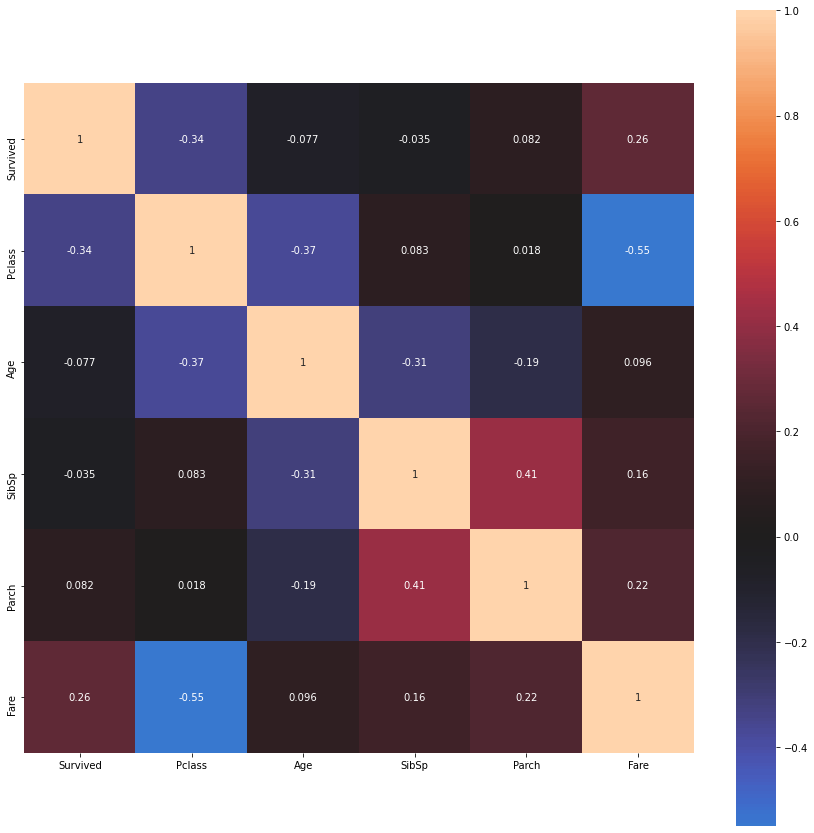

In [1425]:
from seaborn import heatmap
plt.subplots(figsize = (15,15))
heatmap(data.corr(method='pearson'), center=0, square=True, annot=True,)
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


- Age - median()
- Cabin - введем фиктивный номер 'Z', который будет означать отсутствие Cabin
- Embarked - заменим на наиболее чеасто-используемое значение или не будем использовать Embarked вообще, т.к. сильно коррелируется с Pclass      

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [1426]:
y = data['Survived']

In [1427]:
def missing_values_preprocessing(original_data, inplace=False):
    if inplace:
        ret_data = original_data
    else:
        ret_data = original_data.copy()
    ret_data['Age'].fillna(ret_data['Age'].median(), inplace=True)
    ret_data['Embarked'].fillna(ret_data['Embarked'].mode(), inplace=True)
    ret_data['Fare'].fillna(ret_data['Fare'].median(), inplace=True)

    ret_data['Cabin_b'] = ret_data.apply(lambda row: 1 if pd.notnull(row['Cabin'])  else 0, axis=1)
    # change NaN to 'Z'
    # ret_data['Cabin'].fillna('Z', inplace=True)
    # extract letter from Cabin
    # ret_data['Cabin_letter'] = ret_data['Cabin'].str.extract(r'([A-Z]).*')
    return ret_data

In [1428]:
def categorical_features_encoding(original_data):
    ret_data = pd.get_dummies(data=original_data, columns=["Sex"], drop_first=True, )
    ret_data = pd.get_dummies(data=ret_data, columns=["Embarked"],drop_first=True)
    # ret_data = pd.get_dummies(data=ret_data, columns=["Cabin_letter"], drop_first=True)
    return ret_data

In [1429]:
def drop_columns(original_data):
    return original_data.drop(columns=['Cabin', 'Name', 'Ticket', 'Age'], axis=1)

In [1430]:
# Missing Values Preprocessing & Categorical Features Encoding
preprecessed_data = missing_values_preprocessing(data)
preprecessed_data = categorical_features_encoding(preprecessed_data)
preprecessed_data = drop_columns(preprecessed_data)

preprecessed_data = preprecessed_data.drop(columns=['Survived'], axis=1)

In [1435]:
X_train, X_test, y_train, y_test = train_test_split(preprecessed_data, y, test_size=0.2, shuffle=True, random_state=42)

In [1436]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_, {"mean": mean, "std": std}

In [1437]:
def test_model(model, param_grid, model_name):
    print(f'========== test of {model_name} ============')
    clf = GridSearchCV(model, param_grid)
    clf.fit(X_train, y_train)
    best_clf = clf.best_estimator_ 
    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                    clf.cv_results_['std_test_score'][clf.best_index_]

    fit_plot_confusion(clf, X_train, y_train, X_test, y_test)

    y_pred = best_clf.predict(X_test)
    print(f'"{model_name}" accuracy_score = {metrics.accuracy_score(y_pred=y_pred, y_true=y_test)}')
    return best_clf

========== test of LogisticRegression ============


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
INFO:root:{'C': 1.0, 'penalty': 'l1'}


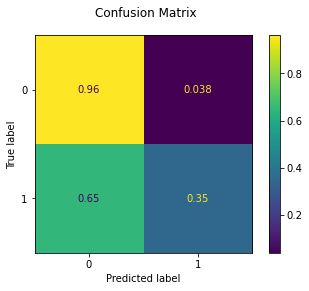

"LogisticRegression" accuracy_score = 0.7094972067039106


In [1438]:
lr_main_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1)
param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}
best_clf = test_model(lr_main_model, param_grid, 'LogisticRegression')

========== test of KNeighborsClassifier ============


INFO:root:{'n_neighbors': 3, 'weights': 'distance'}


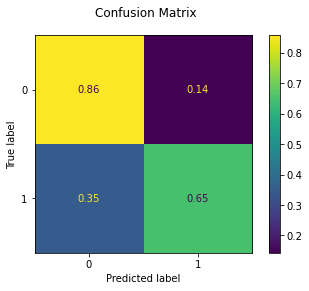

"KNeighborsClassifier" accuracy_score = 0.770949720670391


In [1439]:
param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_main_model = KNeighborsClassifier(n_jobs=-1)
best_clf = test_model(knn_main_model, param_grid, 'KNeighborsClassifier')

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

========== test of LogisticRegression with Pipeline ============


INFO:root:{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}


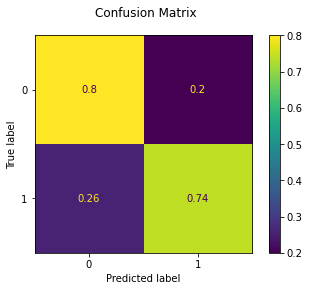

"LogisticRegression with Pipeline" accuracy_score = 0.776536312849162


In [1440]:
lr_main_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1)
param_grid = {'logisticregression__C': [0.01, 0.1, 1.0, 10.0],
                 'logisticregression__penalty': ['l1', 'l2']}

selection_model = RandomForestClassifier(random_state=42)
# pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), lr_main_model)
pipe_selection = make_pipeline(SelectFromModel(selection_model), lr_main_model)
pipe_selection = make_pipeline(StandardScaler(), lr_main_model)

lr_best_clf = test_model(pipe_selection, param_grid, 'LogisticRegression with Pipeline')

========== test of KNeighborsClassifier with Pipeline ============


INFO:root:{'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}


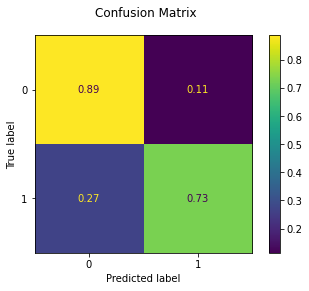

"KNeighborsClassifier with Pipeline" accuracy_score = 0.8212290502793296


In [1441]:
param_grid = {'kneighborsclassifier__n_neighbors': [1, 2, 3, 5, 30, 100], 'kneighborsclassifier__weights': ['uniform', 'distance']}
knn_main_model = KNeighborsClassifier(n_jobs=-1)

selection_model = RandomForestClassifier(random_state=42)
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), knn_main_model)
# pipe_selection = make_pipeline(StandardScaler(), knn_main_model)
# pipe_selection = make_pipeline(SelectFromModel(selection_model), knn_main_model)

knn_best_clf = test_model(pipe_selection, param_grid, 'KNeighborsClassifier with Pipeline')

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [1442]:
# process Kaggle test data

# load test data
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

# Missing Values Preprocessing & Categorical Features Encoding
test_preprecessed_data = missing_values_preprocessing(test)
test_preprecessed_data = categorical_features_encoding(test_preprecessed_data)
test_preprecessed_data = drop_columns(test_preprecessed_data)

# pred = lr_best_clf.predict(test_preprecessed_data)
pred = knn_best_clf.predict(test_preprecessed_data)

pred_df = pd.DataFrame(pred, index=test_preprecessed_data.index, columns=['Survived'])

pred_df.to_csv(os.path.join(PATH, 'titanic', 'submission_knn_without_age_.csv'))
display(pred_df)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


**Результат:**

kaggle score = **0.78708**

kaggle nicname = **Sergey Asadchy**


## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [1445]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [1448]:
pd.set_option('display.max_columns', None)
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [1449]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [1450]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code